In [1]:
%matplotlib inline
import json
import tabulate
import datetime
import numpy as np
import matplotlib.pyplot as plt

def int2dur(x):
    minutes = int(x // 60)
    seconds = int(round(x - minutes * 60))
    return f"{minutes: 3d}m{seconds:02d}s"

def make_cdf(x):
    cdf_x = [0.0]
    cdf_y = [0.0]
    for idx, val in enumerate(x):
        cdf_x.append(val / 60.0)
        cdf_y.append(cdf_y[-1])
        
        cdf_x.append(val / 60.0)
        cdf_y.append((1 + idx) / len(x))
    return [cdf_x, cdf_y]

def analyze_speakers(data, title="", _filter=None):

    if _filter is not None:
        new_data = [_ for _ in data if _filter(_)]
    else:
        new_data = [_ for _ in data]
    speakers = [_ for sublist in new_data for _ in sublist["speakers"]]
    
    if title != "":
        print(f"\n=====[ Analyzing '{title}' ]=====\n")

        
    N_first_female = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "female"])
    N_first_male = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "male"])

    N_last_female = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "female"])
    N_last_male = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "male"])
    
    
    sex = [_["sex"] for _ in speakers]
    duration = [_["duration"] for _ in speakers]

    total_duration = sum(duration)
    female_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "female"]))
    male_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "male"]))
    
    table = {
        "sex": ["female", "male"],
        "N": [len(female_durations), len(male_durations)],
        "N first": [N_first_female, N_first_male],
        "N last": [N_last_female, N_last_male],
        "total": [int2dur(sum(female_durations)), int2dur(sum(male_durations))],
        "percent": [sum(female_durations)/total_duration*100, sum(male_durations)/total_duration*100],
        "min": [int2dur(min(female_durations)), int2dur(min(male_durations))],
        "mean": [int2dur(np.mean(female_durations)), int2dur(np.mean(male_durations))],
        "max": [int2dur(max(female_durations)), int2dur(max(male_durations))],
    }
    print(tabulate.tabulate(table, headers="keys"))
    
    cdf_female_x, cdf_female_y = make_cdf(female_durations)
    cdf_male_x, cdf_male_y = make_cdf(male_durations)
    plt.clf()
    plt.cla()
    plt.plot(cdf_female_x, cdf_female_y, c="m", label="female")
    plt.plot(cdf_male_x, cdf_male_y, c="c", label="male")
    plt.legend()
    plt.show()
    plt.close()

In [2]:
with open("data.json", "r") as stream:
    data = json.load(stream)
    
for idx in range(len(data)):
    print(f"Processing {data[idx]['date']}")
    data[idx]["date"] = datetime.datetime.strptime(data[idx]["date"], "%Y-%m-%d").date()
    for jdx in range(len(data[idx]["speakers"])):
        duration_txt = data[idx]["speakers"][jdx]["duration"]
        minutes, seconds = duration_txt.split(":")
        data[idx]["speakers"][jdx]["duration"] = int(minutes) * 60 + int(seconds)
    
print(f"Found {len(data)} meetings")
meeting_types = set([_["meeting"] for _ in data])
meeting_types

Processing 2023-05-28
Processing 2023-06-04
Processing 2023-06-11
Processing 2023-06-25
Processing 2023-07-02
Processing 2023-07-09
Processing 2023-07-16
Found 7 meetings


{'fast sunday', 'regular'}


=====[ Analyzing 'all speakers' ]=====

sex       N    N first    N last  total      percent  min    mean    max
------  ---  ---------  --------  -------  ---------  -----  ------  ------
female   24          4         2  97m42s     44.0818  0m12s  4m04s   17m22s
male     19          3         5  123m56s    55.9182  0m16s  6m31s   22m40s


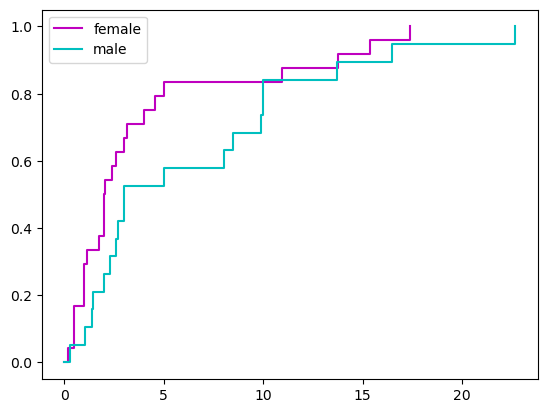


=====[ Analyzing 'regular' ]=====

sex       N    N first    N last  total      percent  min    mean    max
------  ---  ---------  --------  -------  ---------  -----  ------  ------
female    6          4         0  60m33s     37.9386  1m09s  10m06s  17m22s
male     10          1         5  99m03s     62.0614  1m23s  9m54s   22m40s


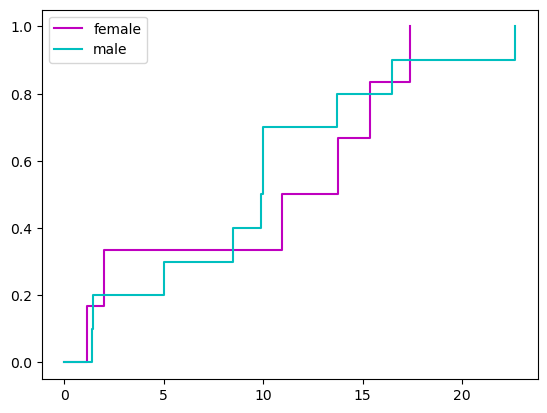


=====[ Analyzing 'fast sunday' ]=====

sex       N    N first    N last  total      percent  min    mean    max
------  ---  ---------  --------  -------  ---------  -----  ------  -----
female   18          0         2  37m09s     59.8872  0m12s  2m04s   5m00s
male      9          2         0  24m53s     40.1128  0m16s  2m46s   8m00s


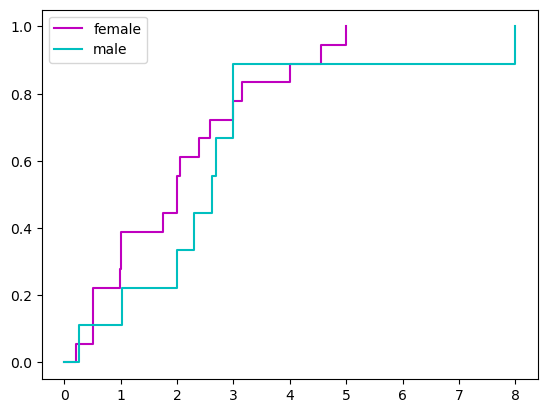

In [3]:
analyze_speakers(data, title="all speakers")

for meeting_type in meeting_types:
    analyze_speakers(data, title=meeting_type, _filter=lambda x: x["meeting"] == meeting_type)